In [1]:
# Since we are not pip installing this package, we will need to manually specify the module path for packages import
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# first import all the requried packages
from inference.input_transform import drum_extraction, drum_to_frame, get_yt_audio
from inference.prediction import predict_drumhit
from inference.transcriber import drum_transcriber
from IPython.display import Audio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
# specify the file path to the audio file in your compauter
path = "the path to the audio file in your computer"

# If you want to transcribe the Audio from a music video on Youtube, just paster the link to below function.
# We will use a 10 second clip from a copyright free music from Youtube, as a demo
path = get_yt_audio("https://youtu.be/60llTxTVIQw") 

In [3]:
# Extract drum track from the Audio File / Youtube Audio
# pass in the path variable we defined in above cell
# specify dir if the pretrained model is saved in other directory
# The most important parameters here are kernel and mode. 
# Kernel let you specify which demixing kernel you want to use. "demucs" is preferred due to higher output quality 
# Mode (only applicable to demucs kernel) let you specify which demixing model you want to use.
# Accept either 'speed' or 'performance'. 'spped' will take ~1 min to demix the song but quality could be worse
# 'performance' will require 4x slower time to process but ensuring best output quality
# the drum_start and drum_end parameter are used to clip the audio to only 10 seconds for this demo

drum_track, sample_rate = drum_extraction(path,
                                          dir='..\inference\pretrained_models\demucs',
                                          kernel='demucs',
                                          mode='performance',
                                          drum_start=29.2,
                                          drum_end=40) 

The demucs kernel is a bag of 4 models. The track will be processed 4 times and output the best one. You will see 4 progress bars per track. The total processing time could take 4-6 mins depends on total Audio length


100%|██████████████████████████████████████████████████████████████████████████| 84.0/84.0 [00:03<00:00, 25.56seconds/s]
100%|██████████████████████████████████████████████████████████████████████████| 84.0/84.0 [00:03<00:00, 25.21seconds/s]
100%|██████████████████████████████████████████████████████████████████████████| 84.0/84.0 [00:03<00:00, 27.65seconds/s]
100%|██████████████████████████████████████████████████████████████████████████| 84.0/84.0 [00:03<00:00, 26.82seconds/s]


In [4]:
# Lets listen to the original 10 seconds track first
y,sr=librosa.load(path, sr=None, offset=29.2, duration=10.8)
Audio(y, rate=sr)

C:\Users\Stanley\anaconda3\envs\annoteators\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [5]:
#Lets check out how the extracted drum track sounds like! 
#compare the output to the original music in above cell, isn't it amazing?
Audio(drum_track, rate=sample_rate)

In [6]:
# pass in the drum_track sample_rate to convert it to a dataframe for prediction task
# A few important parameter here is to specify estimated_bpm and resolution
# It is highly recommended to provide a estimated bpm to improve the bpm detection accuracy
# Resolution is default to 16. it accept either 8/16/32. 
# Resolution parameter control the window size of the onset sound clip.
# 8 means the window size equal to the 8th note duration (calculated by the bpm value), etc.
# There are other parameters you can specify here in special cases, please do help(drum_to_frame) for details

df, bpm = drum_to_frame(drum_track, sample_rate, estimated_bpm=None, resolution=16)


-----------------------------
BPM value not set......BPM will be estimated by the time difference between each detected drum hit, which may not be reliable in some cases.
Please note that inaccurate BPM could lead to miscalculation of note duration and poor model performancce.
-----------------------------
resolution = 16. 
16 note duration is set, this means each of the sliced audio clip length will have the same duration as an 16 note in the song
It is recommended to set the resolution parameter to None, if not familiar with the song structure
-----------------------------
Estimated BPM value: 90.66611842105263


In [9]:
# print the df out and see what info we got
df.head(10)

,audio_clip,sample_start,sample_end,sampling_rate,peak_sample
0,"[-0.0049256342, 0.00016297374, 0.00017518087, ...",8304,16512,47388,9216
1,"[-0.008641008, -0.0065660714, -0.006178885, -0...",22640,30848,47388,23552
2,"[-0.0053446232, 0.011378329, -0.0017524181, -0...",36976,45184,47388,37888
3,"[0.032828897, 0.06667071, 0.012882135, -0.0318...",53360,61568,47388,54272
4,"[0.43602514, 0.23960996, 0.008934598, -0.13760...",67696,75904,47388,68608
5,"[-0.0033369907, 0.0007107163, 0.011415822, 0.0...",82032,90240,47388,82944
6,"[0.0011939429, 0.0006549134, 0.004397402, -0.0...",96368,104576,47388,97280
7,"[-0.005367716, -0.05570257, -0.084850006, -0.0...",111728,119936,47388,112640
8,"[2.2163485e-05, -0.0013015188, -0.0020153255, ...",126064,134272,47388,126976
9,"[-0.0015011985, -0.0050427183, -0.001212796, 0...",140400,148608,47388,141312


In [14]:
#peak sample is the onset detected by the algorythm, which means the time of the drum hit happend.
# Lets plot it on the drum track and seet how it looks like. 
# Before we do so, we need to define a helper function to visualise onset and div_lines

def map_onset_on_track(track, sr, onset, start, stop, _8=None, _16=None, _32=None, _8_3=None, _8_6=None):
    
    start_sample=librosa.time_to_samples(start, sr=sr)
    stop_sample=librosa.time_to_samples(stop, sr=sr)
    
    fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(20,5))

    librosa.display.waveplot(track[start_sample:stop_sample], sr=sr, ax=ax)
    
    ymin=min(ax.get_ylim())
    ymax=max(ax.get_ylim())
    
    onset_line=onset
    onset_line=onset_line-start_sample
    onset_line=pd.Series(onset_line).apply(lambda x:librosa.samples_to_time(x, sr=sr))

    ax.vlines(onset_line, ymin, ymax, color='r', alpha=0.9,
               linestyle='solid', label='Onsets')
    
    if type(_8) ==np.ndarray:
        _8_line=_8
        _8_line=_8_line-start
        ax.vlines(pd.Series(_8_line), ymin, ymax, color='darkorange', alpha=1, linestyle='--', label='8th notes')
    
    if type(_16) ==np.ndarray:
        _16_line=_16
        _16_line=_16_line-start
        ax.vlines(pd.Series(_16_line), ymin, ymax, color='royalblue', alpha=1, linestyle='--', label='16th notes')
    
    if type(_32) ==np.ndarray:
        _32_line=_32
        _32_line=_32_line-start
        ax.vlines(pd.Series(_32_line), ymin, ymax, color='green', alpha=1, linestyle='--', label='32th notes')
        
    if type(_8_3) ==np.ndarray:
        _8_3_line=_8_3
        _8_3_line=_8_3_line-start
        ax.vlines(pd.Series(_8_3_line), ymin, ymax, color='darkviolet', alpha=1, linestyle='dotted', label='8th triplet notes')
    
    if type(_8_6) ==np.ndarray:
        _8_6_line=_8_6
        _8_6_line=_8_6_line-start
        ax.vlines(pd.Series(_8_6_line), ymin, ymax, color='darkviolet', alpha=1, linestyle='dotted', label='8th sixlet notes')
    
    ax.legend()
    
    return fig, ax

(<Figure size 1440x360 with 1 Axes>, <AxesSubplot:xlabel='Time'>)

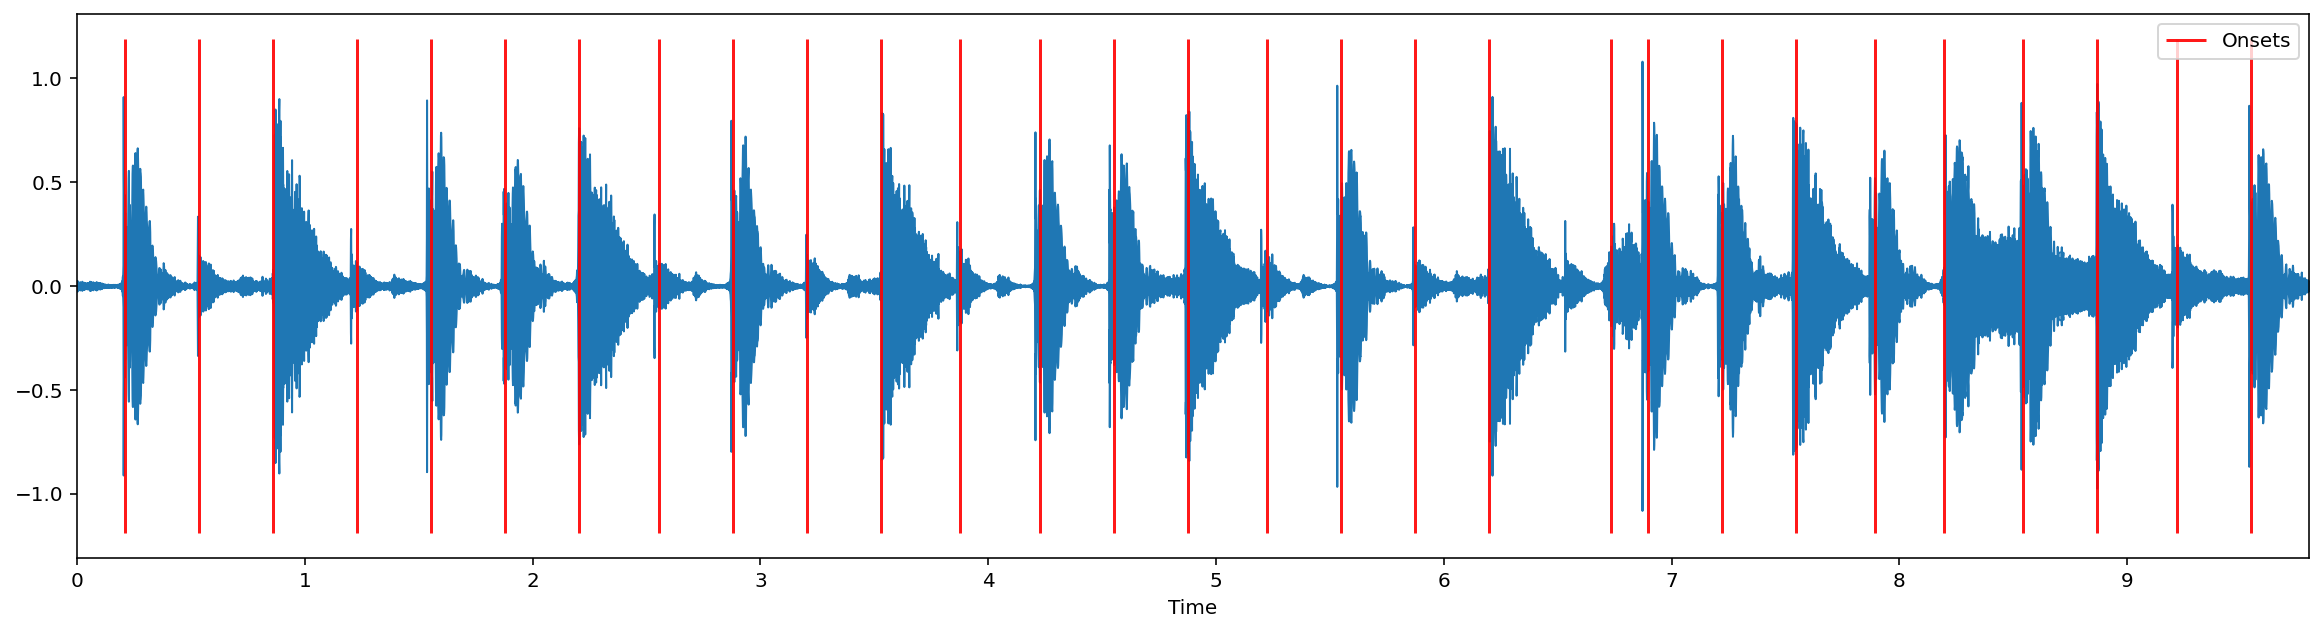

In [20]:
#we will just visualize the first 5 seconds to see how it looks like
# Looks pretty good, right?

map_onset_on_track(track=drum_track,
                   sr=sample_rate,
                   onset=df.peak_sample,
                   start=0,
                   stop=-1)

In [16]:
#If you are feeling good with the onset detection result, then you can start the prediction task
#If not, you may want to fine tune some parameters in earlier tasks

#prediction is easy, just pass in the path to the model, the df we just created and the song sampling rate
prediction_df=predict_drumhit('../inference/pretrained_models/annoteators/complete_network.h5', df, sample_rate)

#let's see what we get as an output
prediction_df

#you may noticed that we got 6 more columns as the prediction result, since this is a multi label classification task
# SD = Snare Drum, HH = Hi-hat, KD = Kick Drum, RC = Ride Cymbal, TT = Tom Tom, CC = Crash Cymbal

,audio_clip,sample_start,sample_end,sampling_rate,peak_sample,SD,HH,KD,RC,TT,CC
0,"[-0.0022214495, 0.0017074628, 0.00102256, -0.0...",8304,16512,47388,9216,0.0,0.0,1.0,0.0,0.0,0.0
1,"[-0.01030758, -0.008411493, -0.007503694, -0.0...",22640,30848,47388,23552,0.0,1.0,0.0,0.0,0.0,0.0
2,"[-0.0045554396, 0.0104076145, -0.0015654704, -...",36976,45184,47388,37888,1.0,0.0,0.0,0.0,0.0,0.0
3,"[0.034539904, 0.06742243, 0.013276829, -0.0327...",53360,61568,47388,54272,0.0,1.0,0.0,0.0,0.0,0.0
4,"[0.4354497, 0.23959896, 0.013849284, -0.135264...",67696,75904,47388,68608,0.0,0.0,1.0,0.0,0.0,0.0
5,"[-0.0017552625, 0.0020112565, 0.011487548, 0.0...",82032,90240,47388,82944,0.0,0.0,1.0,0.0,0.0,0.0
6,"[-0.0016586705, -0.002875723, 0.0008099943, -0...",96368,104576,47388,97280,0.0,0.0,0.0,0.0,1.0,0.0
7,"[-0.009731046, -0.062938765, -0.09238408, -0.0...",111728,119936,47388,112640,1.0,0.0,0.0,0.0,0.0,0.0
8,"[0.0009983702, -0.00016391637, -0.002189226, -...",126064,134272,47388,126976,0.0,0.0,1.0,0.0,0.0,0.0
9,"[-0.0011364733, -0.005034821, -0.0021016384, 0...",140400,148608,47388,141312,0.0,1.0,0.0,0.0,0.0,0.0


In [17]:
#Nice! we can now start constructiing the sheet music.
# We first use the librosa package to get the song duration, becuase we need this info to build the sheet
song_duration = librosa.get_duration(drum_track, sr=sample_rate)

# Then we can initiate the drum_transcriber class
# The drum_transcriber class is a wrapper of many different functions.
# we will need to pass in the prediction_df we get from the prediction task, the song_duration, bpm value and song sampling rate
# Other important parameters are beats_in_measure, note_value, note_offset, song_title

# beats_in_measure, note_value are simply the time signature of the song. beats_in_measure is the upper number, note_value is the lower number
# There is no accurate approach to detect the time signature of a song, so we rely on the user to provide this information
# if beats_in_measure, note_value are not set, it will assume the song has 4/4 time signature.

#note_offset is also an important parameter that tell whether the first detected onset is on the first quarter note of a measure
#If not, please specify the number here to tell which detected onset is on the first quarter note of a measure.
# when note_offset =1, it means the second detected onset is on the first quarter note of a measure
# if you are not sure, just leave it as None, we built a small algorythm to do the trick, but it may not accurate at all time

#it is up to you to decide whether to provide the song_title or not, it will be used as the title of the sheet music only

sheet_music = drum_transcriber(prediction_df,
                               song_duration,
                               bpm,
                               sample_rate,
                               beats_in_measure=4,
                               note_value=4,
                              note_offset=None,
                              song_title='Rock Music')

(<Figure size 1440x360 with 1 Axes>, <AxesSubplot:xlabel='Time'>)

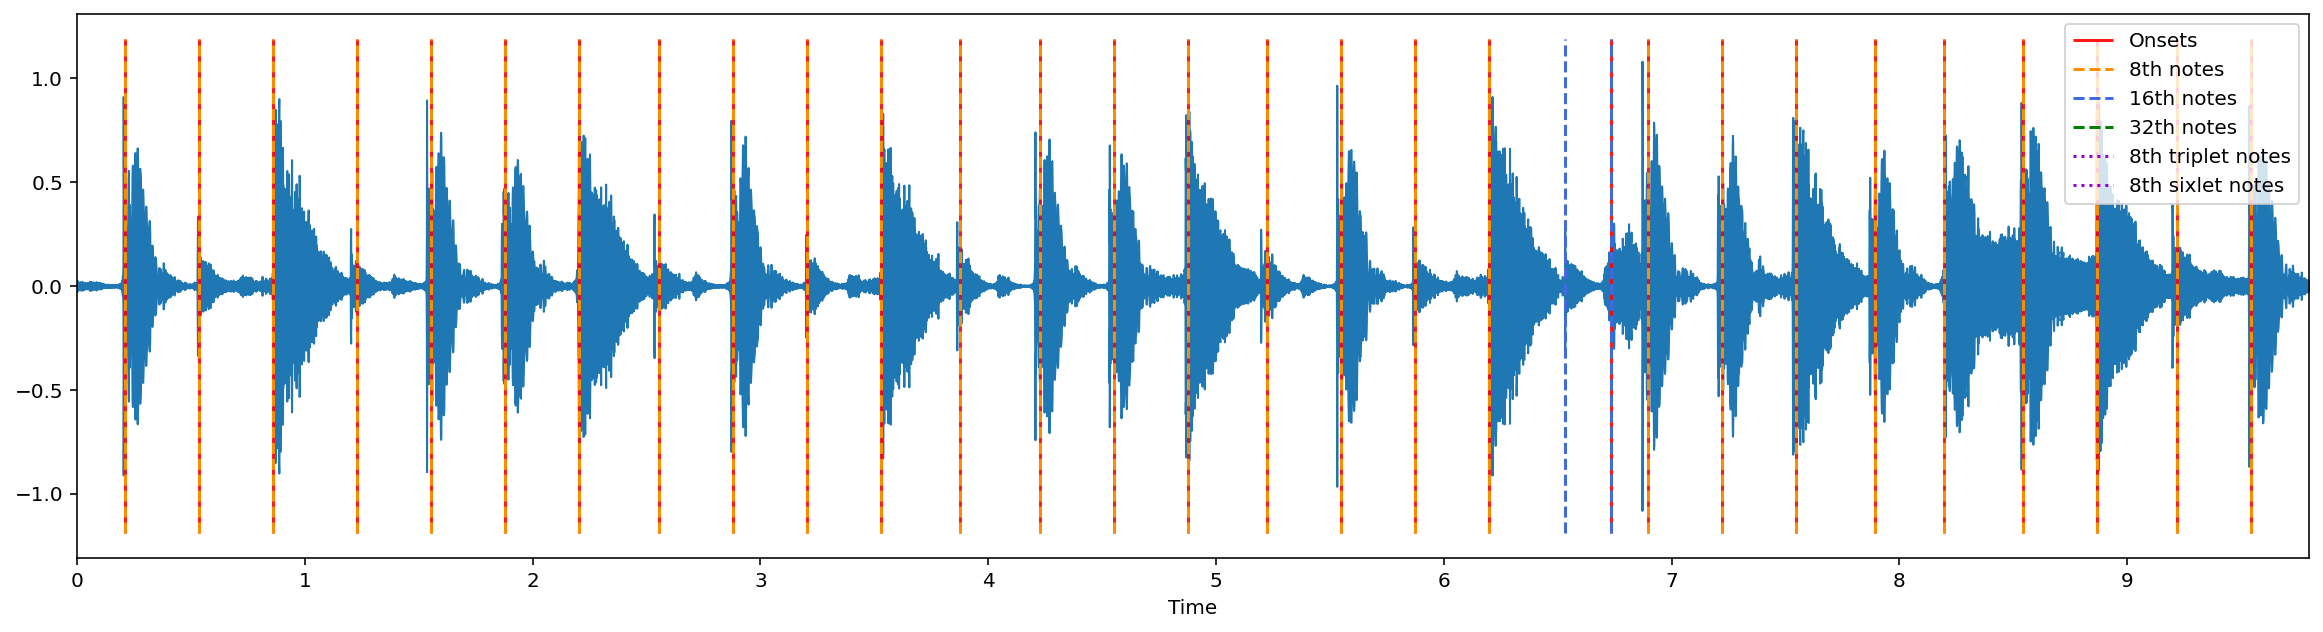

In [19]:
# we can use the some viz function to visualize how the onset mapped to the time grid

map_onset_on_track(track=drum_track,
                   sr=sample_rate,
                   onset=df.peak_sample,
                   start=0,
                   stop=-1,
                   _8=sheet_music.synced_8_div_clean,
                   _16=sheet_music.synced_16_div,
                   _32=sheet_music.synced_32_div,
                   _8_3=sheet_music.synced_8_3_div,
                   _8_6=sheet_music.synced_8_6_div
                  )

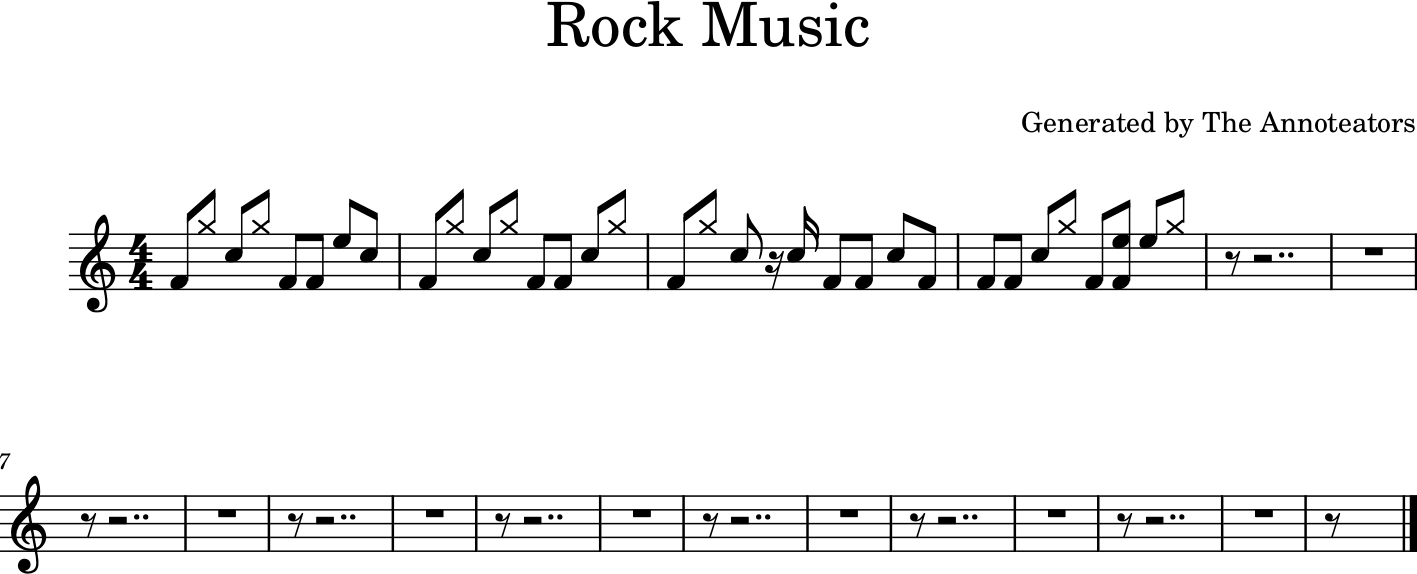

In [21]:
# To display the sheet music in the notebook enviornment, you will need to install musescore first
# Link here https://musescore.org/en/download

# To display the image in notebook env
sheet_music.sheet.show() 

In [22]:
#You can also display the text in musicxml protocal
sheet_music.sheet.show('text')  


{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.metadata.Metadata object at 0x2663b2458b0>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Unpitched object at 0x2663b285310>
    {0.5} <music21.note.Unpitched object at 0x2663b285340>
    {1.0} <music21.note.Unpitched object at 0x2663b285460>
    {1.5} <music21.note.Unpitched object at 0x2663b285520>
    {2.0} <music21.note.Unpitched object at 0x2663b2855e0>
    {2.5} <music21.note.Unpitched object at 0x2663b2856a0>
    {3.0} <music21.note.Unpitched object at 0x2663b285760>
    {3.5} <music21.note.Unpitched object at 0x2663b285820>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.note.Unpitched object at 0x2663b2858e0>
    {0.5} <music21.note.Unpitched object at 0x2663b2859a0>
    {1.0} <music21.note.Unpitched object at 0x2663b285a60>
    {1.5} <music21.note.Unpitched object at 0x2663b285b20>
    {2.0} <music21.note.Unpitched object at 0x2663b285be0>
   

In [15]:
#To export sheet music
sheet_music.sheet.write() # export in MusicXML format
sheet_music.sheet.write(fmt='musicxml.pdf') # export in pdf

In [23]:
# delete the downloaded audio to clean up space
os.remove(path)